Best Statline for MVP Guarantee:
 G       78.750000
GS      78.750000
MP      37.371429
FG       9.817857
FGA     19.525000
FG%      0.505321
3P       1.310714
3PA      3.460714
3P%      0.318786
2P       8.521429
2PA     16.060714
2P%      0.533464
eFG%     0.269839
FT       6.264286
FTA      7.832143
FT%      0.809071
ORB      1.782143
DRB      6.546429
TRB      4.155357
AST      3.060714
STL      0.764286
BLK      0.569643
TOV      3.150000
PF       2.346429
PTS     13.598214
Age     27.607143
dtype: float64

Worst Statline to Be in Top 20:
 G       77.365217
GS      75.234783
MP      36.180870
FG       7.120000
FGA     15.073043
FG%      0.476791
3P       1.026087
3PA      2.776522
3P%      0.300557
2P       6.097391
2PA     12.297391
2P%      0.497252
eFG%     0.254748
FT       4.347826
FTA      5.426957
FT%      0.801930
ORB      1.650435
DRB      4.822609
TRB      3.236087
AST      2.439130
STL      0.673913
BLK      0.368696
TOV      2.609565
PF       2.496522
PTS      9.806087

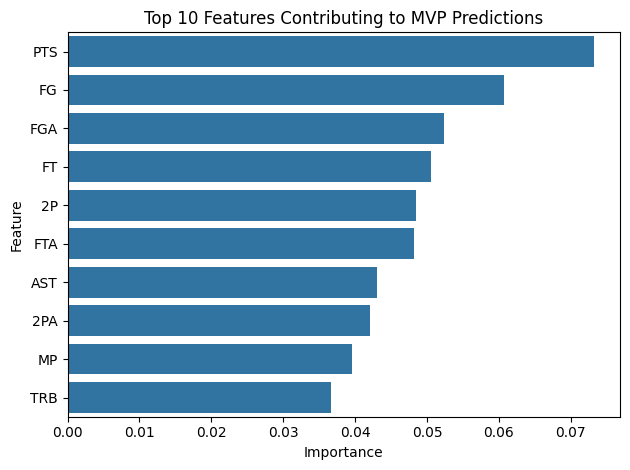

    G  GS    MP  FG  FGA   FG%  3P  3PA    3P%  2P  ...  Tm_POR  Tm_SAC  \
0  82  82  35.0  11   20  0.55   7   12  0.583   7  ...     0.0     0.0   

   Tm_SAS  Tm_SEA  Tm_TOR  Tm_TOT  Tm_UTA  Tm_VAN  Tm_WAS  Tm_WSB  
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[1 rows x 78 columns]
probas is: [[0.07 0.4  0.17 0.08 0.28]]
Prediction Probabilities: {'Not MVP': np.float64(0.07), 'Top 1': np.float64(0.4), 'Top 10': np.float64(0.17), 'Top 20': np.float64(0.08), 'Top 5': np.float64(0.28)}

Predicted MVP Tier for New Player: Top 1


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import re

# Load the dataset
data = pd.read_csv('preprocessed_players.csv')

# Clean `MVP_Rank` column
data['MVP_Rank'] = data['MVP_Rank'].astype(str).apply(lambda x: int(re.sub(r'T', '', x)) if x != 'nan' else None)
data['MVP_Rank'] = data['MVP_Rank'].fillna(float('inf'))  # Retain 'inf' for missing ranks

# Define MVP tiers based on ranking using conditional logic
def assign_mvp_tier(rank):
    if rank == float('inf'):  # Explicitly check for 'inf'
        return 'Not MVP'
    elif rank == 1:
        return 'Top 1'
    elif 2 <= rank <= 5:
        return 'Top 5'
    elif 6 <= rank <= 10:
        return 'Top 10'
    elif 11 <= rank <= 20:
        return 'Top 20'
    else:
        return 'Not MVP'

data['MVP_Tier'] = data['MVP_Rank'].apply(assign_mvp_tier)

# Filter by `G > 65`
data = data[data['G'] > 65]

# Ensure efficiency metrics are properly capped and not altered by weights
# Cap efficiency metrics at 1.0 (100%)
data[['FG%', '3P%', '2P%', 'eFG%', 'FT%']] = data[['FG%', '3P%', '2P%', 'eFG%', 'FT%']].clip(upper=1.0)

# Reweight features excluding efficiency metrics
reweight_features = ['STL', 'TRB', 'AST', 'BLK', 'PTS', 'eFG%']
data[reweight_features] = data[reweight_features] * 0.5

# One-hot encode categorical features
categorical_features = ['Pos', 'Tm']
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
encoded_categorical = pd.DataFrame(
    encoder.fit_transform(data[categorical_features]),
    columns=encoder.get_feature_names_out(categorical_features),
    index=data.index
)

# Combine numeric features and encoded categorical features
numeric_features = [
    'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
    'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Age'
]
X = pd.concat([data[numeric_features], encoded_categorical], axis=1).fillna(0)
y = data['MVP_Tier']

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X, y)

# Identify top predictors of MVP caliber
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Analysis Functions
def best_statline(data, tier='Top 1'):
    """Get the average statline of players in a specific MVP tier."""
    return data[data['MVP_Tier'] == tier][numeric_features].mean()

def closest_statline(player_stats, target_stats, filter_condition=None):
    """Find the player closest to a target statline, with optional filtering."""
    if filter_condition is not None:
        player_stats = player_stats[filter_condition]
    distances = np.linalg.norm(player_stats[numeric_features].values - target_stats.values, axis=1)
    closest_idx = np.argmin(distances)
    return player_stats.iloc[closest_idx]

def best_team_to_win_mvp(data):
    """Find the team with the highest proportion of MVPs."""
    mvp_teams = data[data['MVP_Tier'] == 'Top 1']['Tm'].value_counts()
    return mvp_teams.idxmax(), mvp_teams.max()

def best_position_to_win_mvp(data):
    """Find the position with the highest proportion of MVPs."""
    mvp_positions = data[data['MVP_Tier'] == 'Top 1']['Pos'].value_counts()
    return mvp_positions.idxmax(), mvp_positions.max()

def best_age_to_win_mvp(data):
    """Find the age group most associated with MVP wins."""
    mvp_ages = data[data['MVP_Tier'] == 'Top 1']['Age'].value_counts().sort_index()
    return mvp_ages.idxmax(), mvp_ages.max()

def optimal_games_played(data):
    """Analyze games played by MVP winners."""
    games_played = data[data['MVP_Tier'] == 'Top 1']['G']
    return games_played.mean(), games_played.std()

def efficiency_analysis(data):
    """Analyze consistency metrics like FG%, FT%, eFG% among MVPs."""
    efficiency_stats = ['FG%', 'FT%', 'eFG%']
    return data[data['MVP_Tier'] == 'Top 1'][efficiency_stats].mean()

# # Predict MVP Tier for New Players
# def predict_mvp_tier(player_data):
#     new_player_df = pd.DataFrame([player_data])
#     new_player_encoded = pd.DataFrame(
#         encoder.transform(new_player_df[categorical_features]),
#         columns=encoder.get_feature_names_out(categorical_features),
#         index=new_player_df.index
#     )
#     new_player_numeric = new_player_df[numeric_features]
#     new_player_preprocessed = pd.concat([new_player_numeric, new_player_encoded], axis=1).fillna(0)
#     return model.predict(new_player_preprocessed)[0]


def predict_mvp_tier(player_data):
    new_player_df = pd.DataFrame([player_data])
    new_player_encoded = pd.DataFrame(
        encoder.transform(new_player_df[categorical_features]),
        columns=encoder.get_feature_names_out(categorical_features),
        index=new_player_df.index
    )
    new_player_numeric = new_player_df[numeric_features]
    new_player_preprocessed = pd.concat([new_player_numeric, new_player_encoded], axis=1).fillna(0)

    print(new_player_preprocessed)

    
    probas = model.predict_proba(new_player_preprocessed)
    prob_threshold = 0.8  # Set a reasonable threshold
    print('probas is:', probas)

    print(f"Prediction Probabilities: {dict(zip(model.classes_, probas[0]))}")

    if probas[:, list(model.classes_).index('Top 1')].max() > prob_threshold:
        return 'MVP'
    else:
        return model.predict(new_player_preprocessed)[0]



# Results Interpretation
filtered_data = data[data['MVP_Rank'] != float('inf')]

# Calculate average statlines
average_best_stats = best_statline(filtered_data, 'Top 1')
average_worst_stats = best_statline(filtered_data, 'Top 20')

print("Best Statline for MVP Guarantee:\n", average_best_stats)
print("\nWorst Statline to Be in Top 20:\n", average_worst_stats)

# Find the player closest to the best statline
closest_to_best = closest_statline(data, average_best_stats)
print("\nPlayer Closest to Best Statline:\n", closest_to_best)

# Find the player closest to the worst statline in Top 20
top_20_filter = (data['MVP_Tier'] == 'Top 20')
closest_to_worst = closest_statline(data, average_worst_stats, filter_condition=top_20_filter)
print("\nPlayer Closest to Worst Statline in Top 20:\n", closest_to_worst)

# Additional analysis
best_team, best_team_count = best_team_to_win_mvp(data)
print(f"\nBest Team to Play for to Win MVP: {best_team} with {best_team_count} MVP(s)")

best_pos, best_pos_count = best_position_to_win_mvp(data)
print(f"\nBest Position to Increase MVP Chances: {best_pos} with {best_pos_count} MVP(s)")

best_age, best_age_count = best_age_to_win_mvp(data)
print(f"\nBest Age to Win MVP: {best_age} years old with {best_age_count} MVP(s)")

games_mean, games_std = optimal_games_played(data)
print(f"\nOptimal Games Played for MVP: Mean = {games_mean:.2f}, Std = {games_std:.2f}")

efficiency_means = efficiency_analysis(data)
print("\nKey Efficiency Metrics:\n", efficiency_means)

# Visualizations
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title("Top 10 Features Contributing to MVP Predictions")
plt.tight_layout()
plt.show()

# Example Prediction
example_player = {
    'G': 82, 'GS': 82, 'MP': 35.0, 'FG': 11, 'FGA': 20, 'FG%': 0.55, '3P': 7, '3PA': 12,
    '3P%': 0.583, '2P': 7, '2PA': 12, '2P%': 0.583, 'eFG%': 0.603, 'FT': 6, 'FTA': 7,
    'FT%': 0.857, 'ORB': 0.5, 'DRB': 3.8, 'TRB': 4.3, 'AST': 6.2, 'STL': 2.2, 'BLK': 1.2,
    'TOV': 3, 'PF': 2, 'PTS': 35.3, 'Age': 28, 'Pos': 'SF', 'Tm': 'LAL'
}
predicted_tier = predict_mvp_tier(example_player)

print(f"\nPredicted MVP Tier for New Player: {predicted_tier}")